In [11]:
using Pkg
path_package_toml_init = "/home/nauck/joined_work/dataset_v2/gnn_bs_new_dataset"
Pkg.activate(path_package_toml_init)

using HDF5
using Plots
pyplot()

using JSON
using PowerDynamics

include(joinpath("/p/projects/coen/christian/joined_work/dataset_v2/gnn_bs_new_dataset/src/GNN_BS_new_dataset.jl"))
using .GNN_BS_new_dataset

const num_grids = 10000
const pert_per_node = 100

const grid_index_start = 1
const grid_index_end = 100

const end_simulation_time = 500

const seed_summand = 0
const method = "All"

# Shift is applied to rand() before size scaling, -0.5 shifts mean to 0
const ω_pert_shift = -0.5
const ω_pert_size = 1. # 15.0
const u_pert_size = 1.0

const tries_call_solve = 50

const sim_prop_all = simulation_properties(end_simulation_time, num_grids, pert_per_node, method,
    seed_summand, ω_pert_size, u_pert_size, tries_call_solve)


function simple_snbs_or_surv(input_data,threshold,infeasible,index)
    if index=="all"
        N = size(input_data, 1)
        conv = input_data .< threshold
    else
        N = size(input_data[index],1)
        conv = input_data[index,:] .< threshold
        infeasible = infeasible[index]
    end
    conv = conv .* .!infeasible
    outputs = zeros(N)
    num_pert_per_node = size(input_data, 2)
    for n in 1:N
        outputs[n] = size(findall(conv[n,:] .== 1), 1)
    end
    outputs ./ num_pert_per_node
end

function compute_surv_ω(input_data_min, input_data_max, threshold_low,threshold_high, infeasible, index)
    if index =="all"
        N = size(input_data_min, 1)
        conv = input_data_max .< threshold_high .&& input_data_min .> threshold_low
    else
        N = size(input_data_min[index],1)
        conv = input_data_max[index,:] .< threshold_high .&& input_data_min[index,:] .> threshold_low
        infeasible = infeasible[index]
    end
    conv = conv .* .!infeasible
    outputs = zeros(N)
    num_pert_per_node = size(input_data_min, 2)
    for n in 1:N
        outputs[n] = size(findall(conv[n,:] .== 1), 1)
    end
    outputs ./ num_pert_per_node
end


function compute_joined_snbs(input_data1,input_data2,threshold1,threshold2, infeasible, index)
    if index =="all"
        N = size(input_data1, 1)
        conv = input_data1 .< threshold1 .&& input_data2 .< threshold2
    else
        N = size(input_data1[index],1)
        conv = input_data1[index,:] .< threshold1 .&& input_data2[index,:] .< threshold2
        infeasible = infeasible[index]
    end
    conv = conv .* .!infeasible
    outputs = zeros(N)
    num_pert_per_node = size(input_data1, 2)  
    for n in 1:N
        outputs[n] = size(findall(conv[n,:] .== 1), 1)
    end
    outputs ./ num_pert_per_node
end

function compute_joined_surv(freq_dev_min, freq_dev_max, surv_u_Δt_r, threshold_freq_low, threshold_freq_high, threshold_surv_Δt, infeasible, index)
    if index =="all"
        N = size(freq_dev_min, 1)
        conv_ω = freq_dev_max .< threshold_freq_high .&& freq_dev_min .> threshold_freq_low
        conv_u = surv_u_Δt_r .< threshold_surv_Δt
    else
        N = size(freq_dev_min[index],1)
        conv_ω = freq_dev_max[index,:] .< threshold_freq_high .&& freq_dev_min[index,:] .> threshold_freq_low
        conv_u = surv_u_Δt_r[index,:] .< threshold_surv_Δt
        infeasible = infeasible[index]
    end
    outputs = zeros(N)
    num_pert_per_node = size(freq_dev_min, 2)
    conv = conv_ω .&& conv_u
    conv = conv .* .!infeasible
    for n in 1:N
        outputs[n] = size(findall(conv[n,:] .== 1), 1)
    end
    outputs ./ num_pert_per_node
end
    
    
mutable struct simulation_properties_statistic_properties
    sim_dir
    grid_dir
    sim_prop::simulation_properties
    threshold_snbs_ω ::Float64
    threshold_snbs_u ::Float64 
    threshold_surv_ω_min ::Float64
    threshold_surv_ω_max ::Float64
    threshold_surv_Δt::Float64
    grid_index_start::Int64
    grid_index_end::Int64
end

struct statistic_results
    all_nodes
    pq_nodes
    schiffer_nodes
end

struct snbs_surv_results
    all_snbs_ω::Array{Any, 1}
    all_snbs_u::Array{Any, 1}

    all_surv_u::Array{Any, 1}
    all_surv_ω::Array{Any, 1}

    all_snbs::Array{Any, 1}
    all_surv::Array{Any, 1}
    
end

analyze_dynamics_wF10_PF1 = simulation_properties_statistic_properties(
    "/home/nauck/joined_work/dataset_v2/preliminiary/small_grids/dynamics_wF10_wpert1_upert1",
    "/home/nauck/joined_work/dataset_v2/preliminiary/small_grids/grid_generation/run001_wF10/grids/",
    sim_prop_all,
    .1,
    .1,
    -1,
    1,
    5.,
    1,
    100
    )

analyze_dynamics_wF10_PF15 = simulation_properties_statistic_properties(
    "/home/nauck/joined_work/dataset_v2/preliminiary/small_grids/dynamics_wF10_wpert15_upert15",
    "/home/nauck/joined_work/dataset_v2/preliminiary/small_grids/grid_generation/run001_wF10/grids/",
    sim_prop_all,
    .1,
    .1,
    -15,
    15,
    5.,
    1,
    100
    )

analyze_dynamics_wF8_PF15 = simulation_properties_statistic_properties(
    "/home/nauck/joined_work/dataset_v2/preliminiary/small_grids/dynamics_wF8_wpert15_upert15",
    "/home/nauck/joined_work/dataset_v2/preliminiary/small_grids/grid_generation/run002_wF8/grids/",
    sim_prop_all,
    .1,
    .1,
    -15,
    15,
    5.,
    1,
    100
    )

analyze_dynamics_wF6_PF15 = simulation_properties_statistic_properties(
    "/home/nauck/joined_work/dataset_v2/preliminiary/small_grids/dynamics_wF6_wpert15_upert15",
    "/home/nauck/joined_work/dataset_v2/preliminiary/small_grids/grid_generation/run003_wF6/grids/",
    sim_prop_all,
    .1,
    .1,
    -15,
    15,
    5.,
    1,
    100
    )


function get_index_nodetype(pg)
    num_nodes = size(pg.nodes,1)
    index_pq = []
    index_schiffer = []
    for i in 1: num_nodes
        if typeof(pg.nodes[i]) == PQAlgebraic
            append!(index_pq,i)
        elseif typeof(pg.nodes[i]) == SchifferApprox
            append!(index_schiffer,i)
        end
    end
    return index_pq, index_schiffer
end


function analyze_results_from_sim(input_info)
    all_snbs_ω = []
    all_snbs_u = []
    all_surv_u = []
    all_surv_ω = []
    all_snbs = []
    all_surv = []
    
    
    all_snbs_ω_pq = []
    all_snbs_u_pq = []
    all_surv_u_pq = []
    all_surv_ω_pq = []
    all_snbs_pq = []
    all_surv_pq = []
    
    
    all_snbs_ω_schiffer = []
    all_snbs_u_schiffer = []
    all_surv_u_schiffer = []
    all_surv_ω_schiffer = []
    all_snbs_schiffer = []
    all_surv_schiffer = []
    
    
    for r in input_info.grid_index_start:input_info.grid_index_end
        id = lpad(r, length(digits(input_info.sim_prop.num_grids)), '0')
        file_name = string(input_info.sim_dir, "/dynamics_", id, ".h5")

        max_final_frequency, max_frequency_dev, min_frequency_dev, final_diff_v, surv_u_Δt_r, infeasible_int =  h5open(file_name, "r") do file
            read(file, "max_final_frequency", "max_frequency_dev", "min_frequency_dev", "final_diff_v", "surv_u_Δt_r", "infeasible")
        end
        infeasible = infeasible_int .> 0
        grid_name = string(input_info.grid_dir, "/grid_", id, ".json")
        pg = read_powergrid_schiffer(grid_name, Json)
        index_pq, index_schiffer = get_index_nodetype(pg)
        
        
        threshold_snbs_ω = input_info.threshold_snbs_ω
        threshold_snbs_u = input_info.threshold_snbs_u
        threshold_surv_ω_min = input_info.threshold_surv_ω_min
        threshold_surv_ω_max = input_info.threshold_surv_ω_max
        threshold_surv_Δt = input_info.threshold_surv_Δt   

        # all
        tmp_snbs_ω = simple_snbs_or_surv(max_final_frequency,threshold_snbs_ω, infeasible, "all")
        all_snbs_ω = vcat(all_snbs_ω, tmp_snbs_ω)
        
        tmp_snbs_u = simple_snbs_or_surv(final_diff_v,threshold_snbs_u, infeasible, "all")
        all_snbs_u = vcat(all_snbs_u, tmp_snbs_u)

        tmp_surv_u = simple_snbs_or_surv(surv_u_Δt_r,threshold_surv_Δt, infeasible, "all")
        all_surv_u = vcat(all_surv_u,tmp_surv_u)

        tmp_surv_ω = compute_surv_ω(min_frequency_dev,max_frequency_dev,threshold_surv_ω_min, threshold_surv_ω_max, infeasible, "all")
        all_surv_ω = vcat(all_surv_ω, tmp_surv_ω)

        tmp_snbs = compute_joined_snbs(max_final_frequency,final_diff_v,threshold_snbs_ω,threshold_snbs_u, infeasible, "all")
        all_snbs = vcat(all_snbs, tmp_snbs)
    
        tmp_surv = compute_joined_surv(min_frequency_dev, max_frequency_dev, surv_u_Δt_r, threshold_surv_ω_min, threshold_surv_ω_max, threshold_surv_Δt, infeasible,  "all")
        all_surv = vcat(all_surv, tmp_surv)
        # pq
        tmp_snbs_ω_pq = simple_snbs_or_surv(max_final_frequency,threshold_snbs_ω, infeasible, index_pq)
        all_snbs_ω_pq = vcat(all_snbs_ω_pq, tmp_snbs_ω_pq)
        
        tmp_snbs_u_pq = simple_snbs_or_surv(final_diff_v,threshold_snbs_u, infeasible, index_pq)
        all_snbs_u_pq = vcat(all_snbs_u_pq, tmp_snbs_u_pq)
        
        tmp_surv_u_pq = simple_snbs_or_surv(surv_u_Δt_r,threshold_surv_Δt, infeasible, index_pq)
        all_surv_u_pq = vcat(all_surv_u_pq,tmp_surv_u_pq)
        
        tmp_surv_ω_pq = compute_surv_ω(min_frequency_dev,max_frequency_dev,threshold_surv_ω_min, threshold_surv_ω_max, infeasible, index_pq)
        all_surv_ω_pq = vcat(all_surv_ω_pq, tmp_surv_ω_pq)
        
        tmp_snbs_pq = compute_joined_snbs(max_final_frequency,final_diff_v,threshold_snbs_ω,threshold_snbs_u, infeasible, index_pq)
        all_snbs_pq = vcat(all_snbs_pq, tmp_snbs_pq)
        
        tmp_surv_pq = compute_joined_surv(min_frequency_dev, max_frequency_dev, surv_u_Δt_r, threshold_surv_ω_min, threshold_surv_ω_max, threshold_surv_Δt, infeasible, index_pq)
        all_surv_pq = vcat(all_surv_pq, tmp_surv_pq)
        
        # schiffer
        tmp_snbs_ω_schiffer = simple_snbs_or_surv(max_final_frequency,threshold_snbs_ω, infeasible, index_schiffer)
        all_snbs_ω_schiffer = vcat(all_snbs_ω_schiffer, tmp_snbs_ω_schiffer)
        
        tmp_snbs_u_schiffer = simple_snbs_or_surv(final_diff_v,threshold_snbs_u, infeasible, index_schiffer)
        all_snbs_u_schiffer = vcat(all_snbs_u_schiffer, tmp_snbs_u_schiffer)
        
        tmp_surv_u_schiffer = simple_snbs_or_surv(surv_u_Δt_r,threshold_surv_Δt, infeasible, index_schiffer)
        all_surv_u_schiffer = vcat(all_surv_u_schiffer,tmp_surv_u_schiffer)
        
        tmp_surv_ω_schiffer = compute_surv_ω(min_frequency_dev,max_frequency_dev,threshold_surv_ω_min, threshold_surv_ω_max, infeasible, index_schiffer)
        all_surv_ω_schiffer = vcat(all_surv_ω_schiffer, tmp_surv_ω_schiffer)
        
        tmp_snbs_schiffer = compute_joined_snbs(max_final_frequency,final_diff_v,threshold_snbs_ω,threshold_snbs_u, infeasible, index_schiffer)
        all_snbs_schiffer = vcat(all_snbs_schiffer, tmp_snbs_schiffer)
        
        tmp_surv_schiffer = compute_joined_surv(min_frequency_dev, max_frequency_dev, surv_u_Δt_r, threshold_surv_ω_min, threshold_surv_ω_max, threshold_surv_Δt, infeasible, index_schiffer)
        all_surv_schiffer = vcat(all_surv_schiffer, tmp_surv_schiffer)
                
    end
    all_nodes_results = snbs_surv_results(all_snbs_ω, all_snbs_u, all_surv_u, all_surv_ω, all_snbs, all_surv)
    pq_results = snbs_surv_results(all_snbs_ω_pq, all_snbs_u_pq, all_surv_u_pq, all_surv_ω_pq, all_snbs_pq, all_surv_pq)
    schiffer_results = snbs_surv_results(all_snbs_ω_schiffer, all_snbs_u_schiffer, all_surv_u_schiffer, all_surv_ω_schiffer, all_snbs_schiffer, all_surv_schiffer)
    return statistic_results(all_nodes_results, pq_results, schiffer_results)
end

function plot_results(result)
    l = @layout [a b; c d; e f]
    all_snbs_ω, all_snbs_u, all_surv_u, all_surv_ω, all_snbs, all_surv = result.all_snbs_ω, result.all_snbs_u, result.all_surv_u, result.all_surv_ω, result.all_snbs, result.all_surv
    p1 = histogram(all_snbs_ω, legend=:false, title = "snbs_ω", normalize=:probability)
    p2 = histogram(all_surv_ω, legend=:false, title = "surv_ω", normalize=:probability)
    p3 = histogram(all_snbs_u, legend=:false, title = "snbs_u", normalize=:probability)
    p4 = histogram(all_surv_u, legend=:false, title = "surv_u", normalize=:probability)
    p5 = histogram(all_snbs, legend=:false, title = "snbs", normalize=:probability)
    p6 = histogram(all_surv, legend=:false, title = "surv",normalize=:probability);
    plot(p1, p2, p3, p4, p5, p6, layout = l)
end

  Activating project at `~/joined_work/dataset_v2/gnn_bs_new_dataset`


plot_results (generic function with 1 method)

In [7]:
res_dynamics_wF10_PF1 = analyze_results_from_sim(analyze_dynamics_wF10_PF1)
res_dynamics_wF10_PF15 = analyze_results_from_sim(analyze_dynamics_wF10_PF15);
res_dynamics_wF8_PF15 = analyze_results_from_sim(analyze_dynamics_wF8_PF15)
res_dynamics_wF6_PF15 = analyze_results_from_sim(analyze_dynamics_wF6_PF15)
# ;

# weightFactor10, perturbationFactor 1

## all nodes

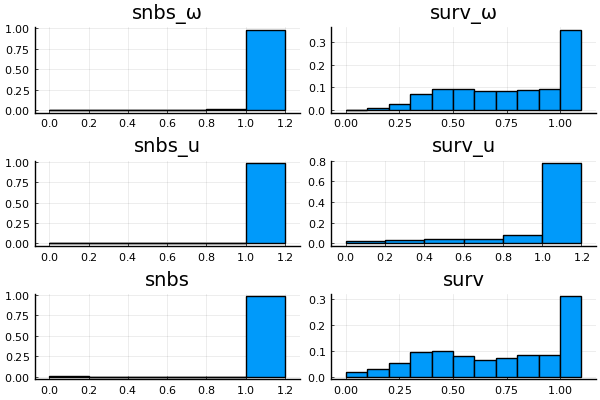

In [12]:
plot_results(res_dynamics_wF10_PF1.all_nodes)

## pq nodes

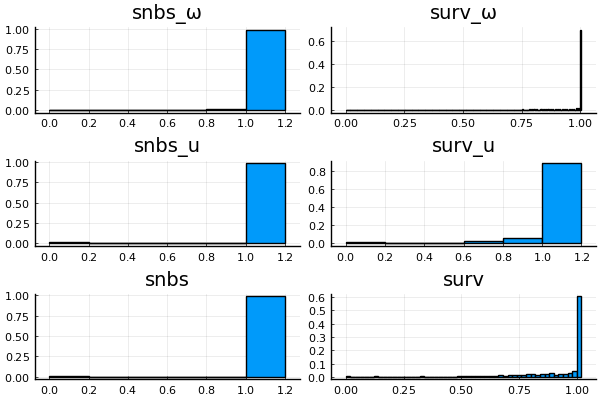

In [13]:
plot_results(res_dynamics_wF10_PF1.pq_nodes)

## schiffer nodes

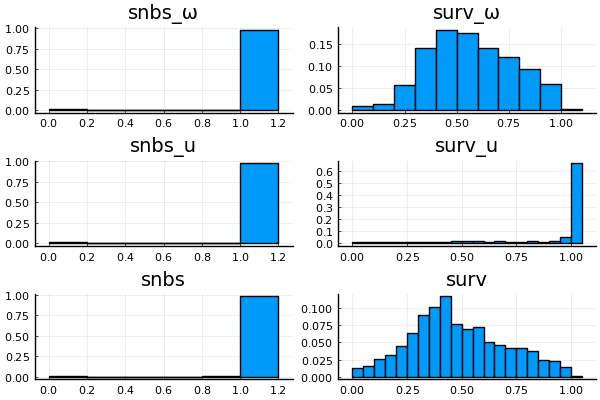

In [14]:
plot_results(res_dynamics_wF10_PF1.schiffer_nodes)

# weightFactor10, perturbationFactor 15

## all nodes

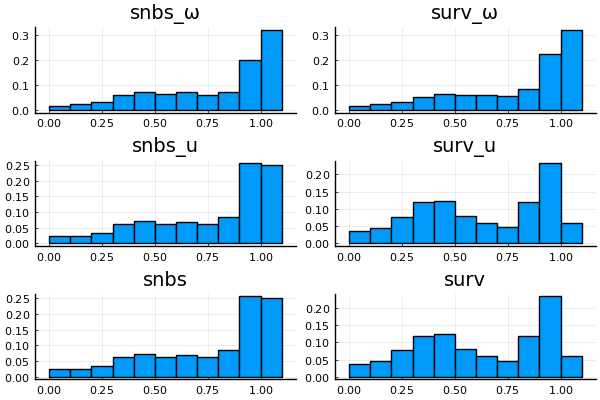

In [15]:
plot_results(res_dynamics_wF10_PF15.all_nodes)

## pq nodes

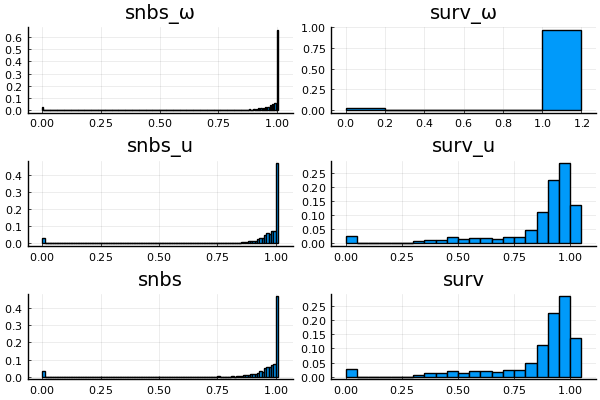

In [16]:
plot_results(res_dynamics_wF10_PF15.pq_nodes)

## schiffer nodes

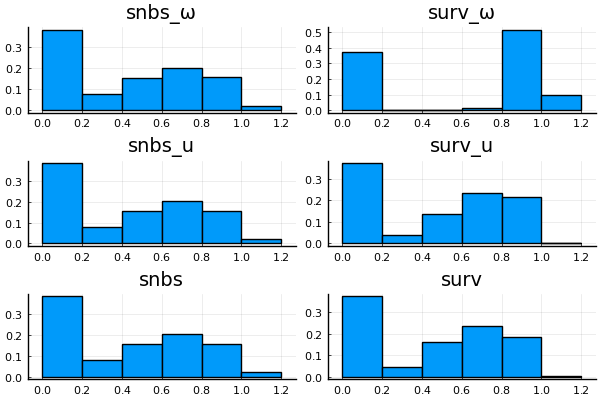

In [17]:
plot_results(res_dynamics_wF10_PF15.schiffer_nodes)

# weightFactor8, perturbationFactor 15

## all nodes

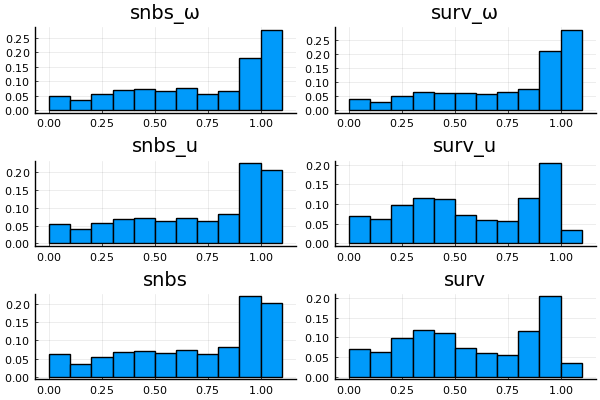

In [18]:
plot_results(res_dynamics_wF8_PF15.all_nodes)

## pq nodes

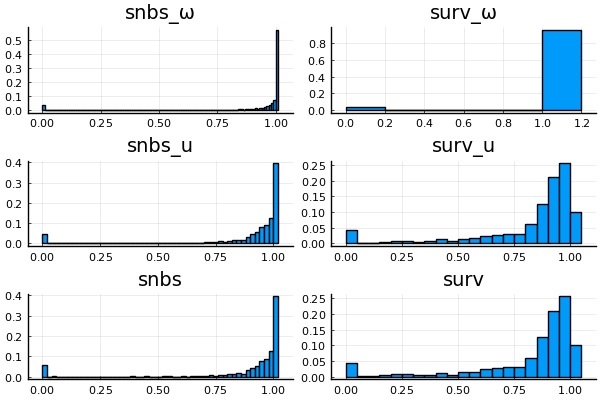

In [19]:
plot_results(res_dynamics_wF8_PF15.pq_nodes)

## schiffer nodes

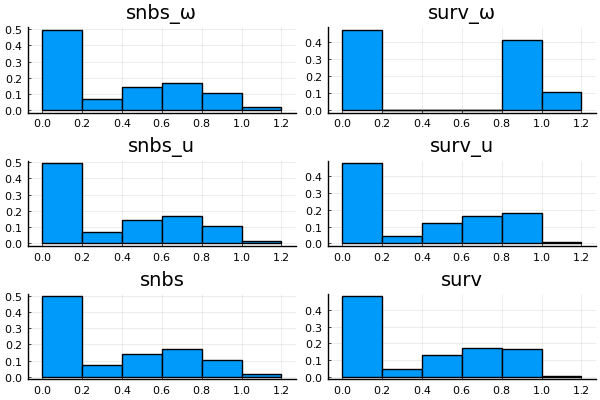

In [20]:
plot_results(res_dynamics_wF8_PF15.schiffer_nodes)

# weightFactor6, perturbationFactor 15

## all nodes

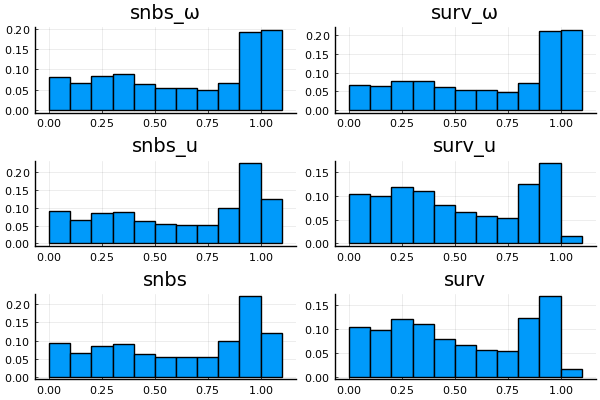

In [21]:
plot_results(res_dynamics_wF6_PF15.all_nodes)

## pq nodes

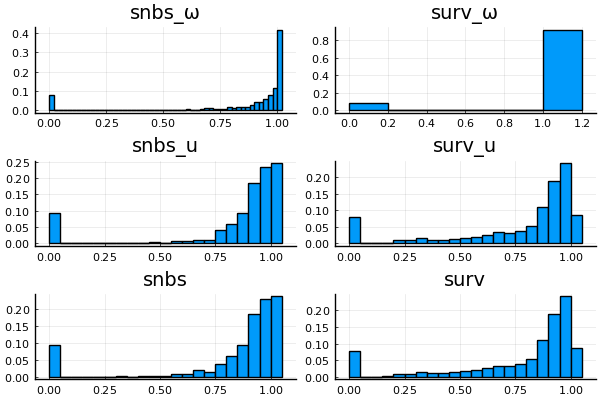

In [22]:
plot_results(res_dynamics_wF6_PF15.pq_nodes)

## schiffer nodes

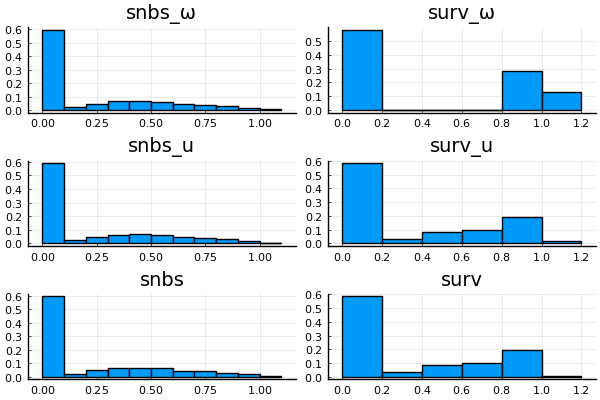

In [23]:
plot_results(res_dynamics_wF6_PF15.schiffer_nodes)

# debug

In [11]:
input_info = analyze_dynamics_wF10_PF1

r = 1
id = lpad(r, length(digits(input_info.sim_prop.num_grids)), '0')
file_name = string(input_info.sim_dir, "/dynamics_", id, ".h5")

max_final_frequency, max_frequency_dev, min_frequency_dev, final_diff_v, surv_u_Δt_r =  h5open(file_name, "r") do file
    read(file, "max_final_frequency", "max_frequency_dev", "min_frequency_dev", "final_diff_v", "ll")
end

grid_name = string(input_info.grid_dir, "/grid_", id, ".json")
pg = read_powergrid_schiffer(grid_name, Json)
index_pq, index_schiffer = get_index_nodetype(pg)

(Any[3, 5, 9, 11, 13, 14, 15, 18, 21, 23, 25, 26, 27], Any[1, 2, 4, 6, 7, 8, 10, 12, 16, 17, 19, 20, 22, 24, 28, 29, 30])

In [13]:
a,b = get_index_nodetype(pg)

(Any[3, 5, 9, 11, 13, 14, 15, 18, 21, 23, 25, 26, 27], Any[1, 2, 4, 6, 7, 8, 10, 12, 16, 17, 19, 20, 22, 24, 28, 29, 30])

In [16]:
size(b)

(17,)

In [14]:
num_nodes = size(pg.nodes,1)
index_pq = []
index_schiffer = []
for i in 1: num_nodes
    if typeof(pg.nodes[i]) == :PQAlgebraic
        append!(index_pq,i)
    elseif typeof(pg.nodes[i]) == SchifferApprox
        append!(index_schiffer,i)
    end
end
return index_pq, index_schiffer

(Any[], Any[])